# Regression with Orbit

In this notebook, we want to demonstartate how to use the different arguments in the model classes (DLT) to realize different setups for the regressors. Those could be very useful in practice when tuning the models. Here includes two example, one with the icliams dataset and one for the simulation data.

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from orbit.models.dlt import DLTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.simulation import make_regression
from orbit.constants.palette import QualitativePalette

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import minmax_scale
from pylab import rcParams

rcParams['figure.figsize'] = 14, 8
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [14, 8]

%matplotlib inline

# Will iclaims Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries from Jan 2010 - Jan 2021. This aims to mimick the dataset from the paper "Predicting the Present with Bayesian Structural Time Series" by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).

In [39]:
# load data
df = pd.read_csv('./data/iclaims_example_v2.csv', parse_dates=['week'])

date_col = 'week'
response_col = 'claims'
df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

We preprocess the data by log transformation to turn model from `additive` to `multiplicative`.

In [40]:
# log transfer
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

In [41]:
df.tail(5)

,week,claims,trend.unemploy,trend.filling,trend.job
570,2020-12-06,13.771008,2.086280,0.164040,-0.216098
571,2020-12-13,13.755665,2.086280,0.238148,-0.216098
572,2020-12-20,13.679623,2.240431,0.432304,-0.473927
573,2020-12-27,13.646704,2.469273,0.144622,-0.416768
574,2021-01-03,13.734379,2.469273,0.083997,-0.216098


We can see form the plot below, there are seasonlity trend and as well as a huge changpoint due the impact of COVID-19.

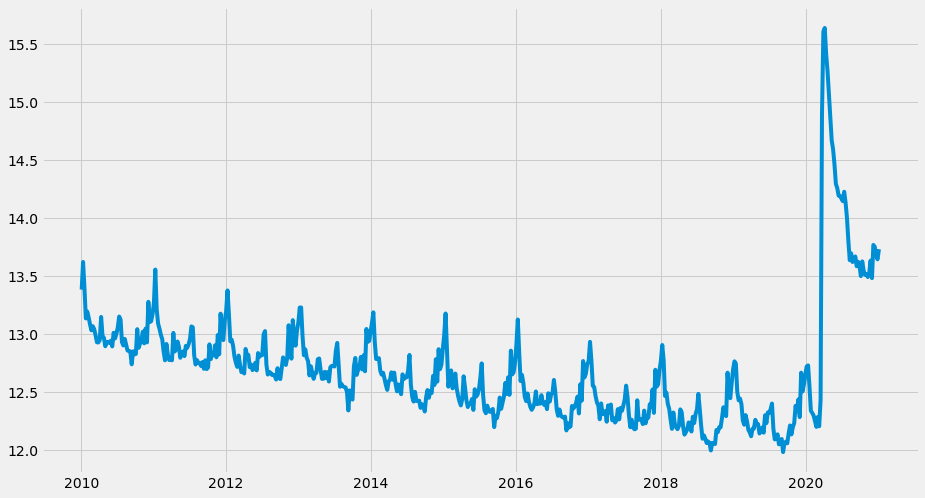

In [39]:
plt.plot(df['week'], df['claims'])

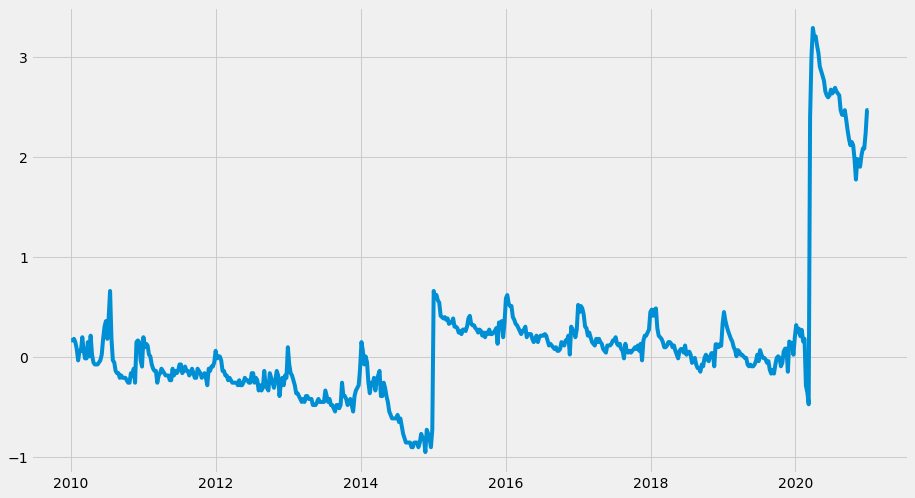

In [80]:
plt.plot(df['week'], df['trend.unemploy'])

# Using the Full Data

In [244]:
# split the dataset
# inlucing one week's data of March
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]

## Without Regression

We will use the DLT models here to compare the model performance without vs. with regression.

In [245]:
dlt = DLTFull(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888
)

In [246]:
%%time
dlt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 151 ms, sys: 192 ms, total: 343 ms
Wall time: 9.25 s


In [247]:
predicted_df = dlt.predict(df=test_df)

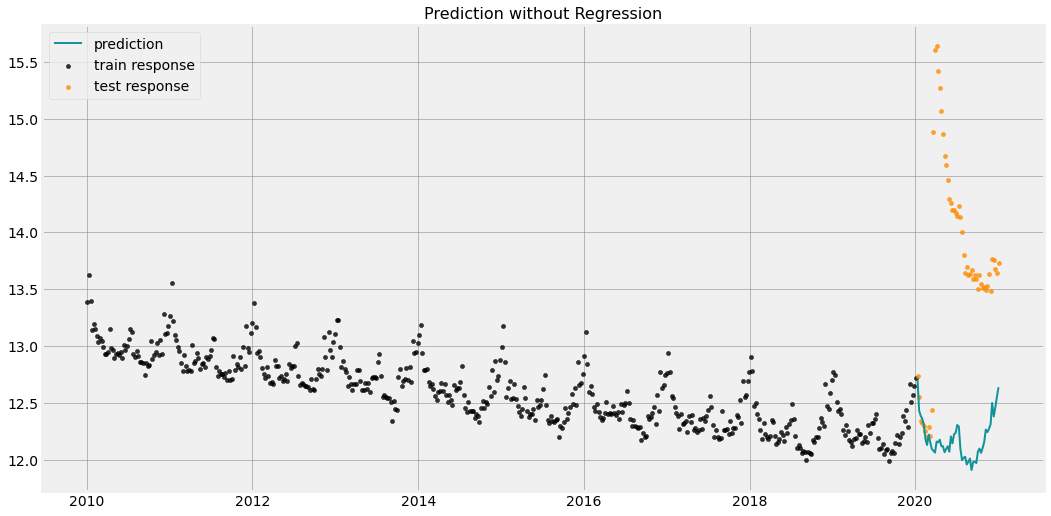

In [248]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction without Regression')

## With Regression

The regressor columns can be supplied via argument `regressor_col`. Their signs can be specified via `regressor_sign`, with values either '=' (regular, no restriction) or '+' (positive). These two lists should be of the same lenght. The default values of `regressor_sign` is all '='.

Also, note that in general, a better performance can be acheived in regressions with `infer_method=mcmc` due to potential high dimensional distributions of parameters. We will use `mcmc` as sample method in following examples.

### Regressor with the sign

In [249]:
REGRESSOR_COL = ['trend.unemploy', 'trend.filling', 'trend.job']
dlt_reg = DLTFull(
    response_col=response_col,
    date_col=date_col,
    regressor_col=REGRESSOR_COL,
    regressor_sign=["+", '+', '='], 
    seasonality=52,
    seed=8888
)
dlt_reg.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


The estimated regressor coefficients can be retrieved via `.aggregated_posteriors`.

In [250]:
dlt_reg.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Positive,0.045500
1,trend.filling,Positive,0.072929
2,trend.job,Regular,-0.035232


In [251]:
predicted_df_reg = dlt_reg.predict(test_df)

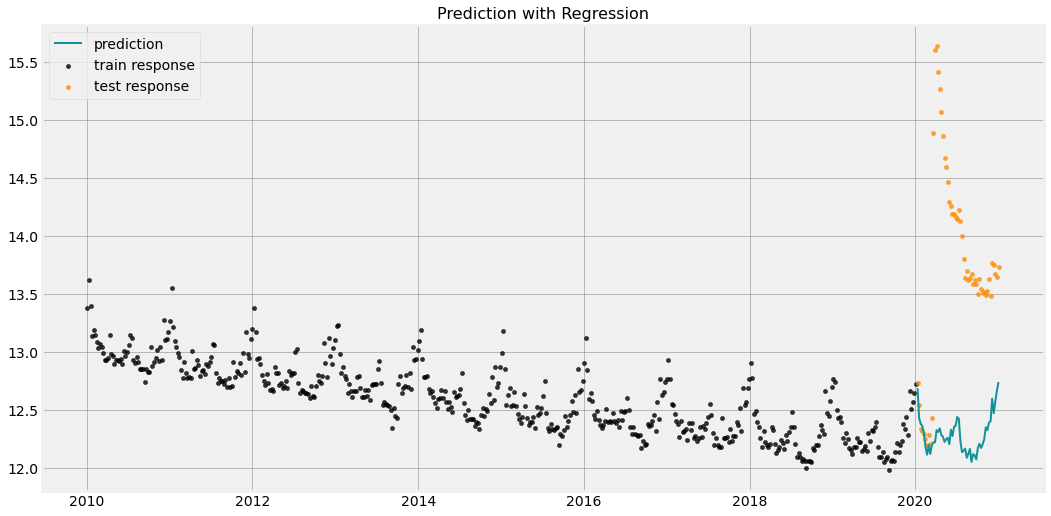

In [252]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction with Regression')

### Adjust pirors for regressor beta and standard deviation

In the model, it is assumed $$\beta \sim Gaussian(\beta_{prior}, \sigma_{prior})$$

The default values for $\beta_{prior}$ and $\sigma_{prior}$ are 0 and 1, respectively.

Users could adjust them via arguments `regressor_beta_prior` and `regressor_sigma_prior`. These two lists should be of the same lenght as `regressor_col`.

In [253]:
dlt_reg_adjust = DLTFull(
    response_col=response_col,
    date_col=date_col,
    regressor_col=REGRESSOR_COL,
    regressor_sign=["+", '+', '='], 
    regressor_beta_prior=[0.05, 0.05, 0],
    regressor_sigma_prior=[0.1, 0.1, 0.1],
    seasonality=52,
    seed=1
)
dlt_reg_adjust.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


One can notice the significant changes in the estimted coefficients by using different priors.

In [254]:
dlt_reg_adjust.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Positive,0.049388
1,trend.filling,Positive,0.073025
2,trend.job,Regular,-0.032816


In [255]:
predicted_df_reg_adjust = dlt_reg_adjust.predict(test_df)

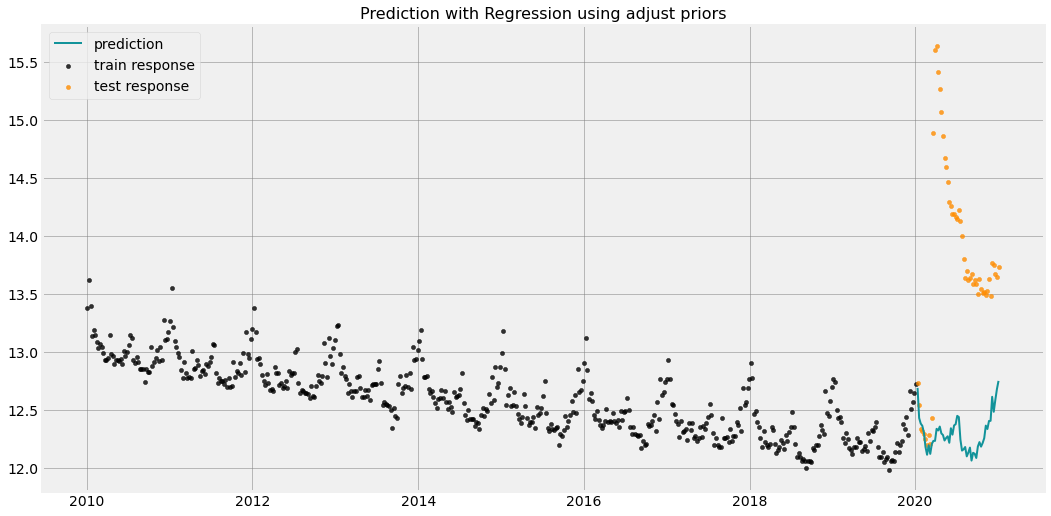

In [256]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg_adjust, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction with Regression using adjust priors')

### Use data-driven sigma for each coefficients

Instead of using fixed standard deviations for regressors, a hyperprior can be assigned to them, i.e.
$$\sigma_\beta \sim \text{Half-Cauchy}(0, \text{ridge_scale})$$

This can be done by setting `regression_penalty="auto_ridge"`.  Notice there is hyperprior `auto_ridge_scale` for tuning with a default of `0.5`.

In [257]:
dlt_reg_ridge = DLTFull(
    response_col=response_col,
    date_col=date_col,
    regressor_col=REGRESSOR_COL,
    regressor_sign=["+", '+', '='],
    seasonality=52,
    seed=1,
    regression_penalty="auto_ridge",
    auto_ridge_scale=0.5,
)
dlt_reg_ridge.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [258]:
dlt_reg_ridge.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Positive,0.045976
1,trend.filling,Positive,0.063448
2,trend.job,Regular,-0.028678


In [259]:
predicted_df_reg_ridge = dlt_reg_ridge.predict(test_df)

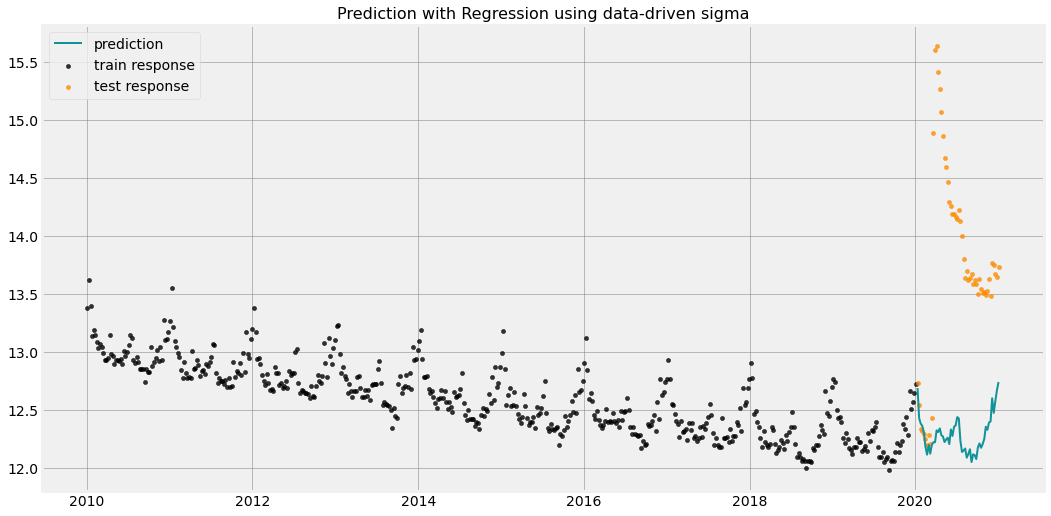

In [260]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg_ridge, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction with Regression using data-driven sigma')

# Only using the data back to 2018

In [42]:
# split the dataset
# inlucing one week's data of March
test_size = 52
train_df = df[df['week'] > '2018-01-01'][:-test_size]
test_df = df[df['week'] > '2018-01-01'][-test_size:]

## Without Regression

In [43]:
dlt = DLTFull(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888
)

In [44]:
%%time
dlt.fit(df=train_df)

CPU times: user 324 ms, sys: 157 ms, total: 481 ms
Wall time: 12.2 s


In [45]:
predicted_df = dlt.predict(df=test_df)

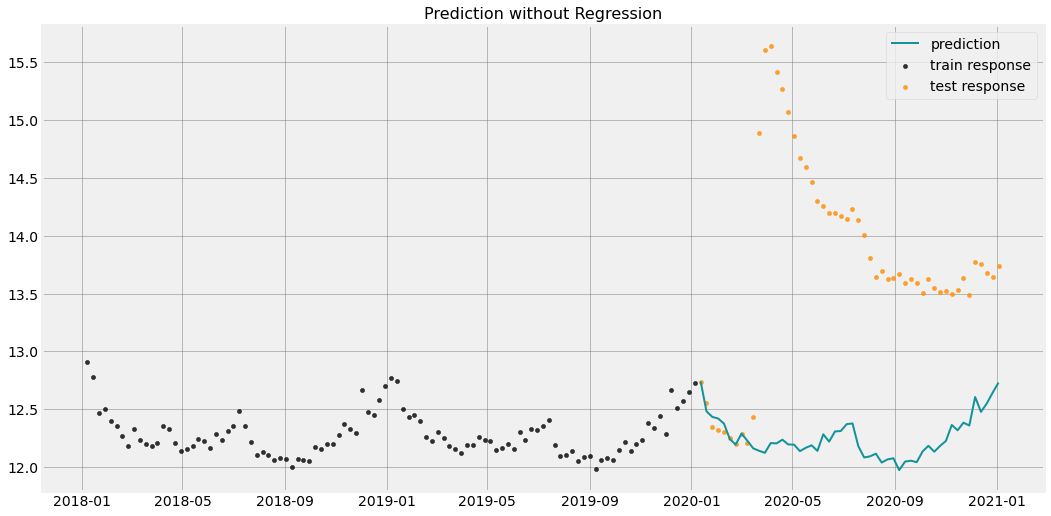

In [46]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction without Regression')

## With Regression

### Regressor with the sign

In [47]:
REGRESSOR_COL = ['trend.unemploy', 'trend.filling', 'trend.job']
dlt_reg = DLTFull(
    response_col=response_col,
    date_col=date_col,
    regressor_col=REGRESSOR_COL,
    regressor_sign=["+", '+', '='], 
    seasonality=52,
    seed=8888
)
dlt_reg.fit(df=train_df)

The estimated regressor coefficients can be retrieved via `.aggregated_posteriors`.

In [48]:
dlt_reg.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Positive,0.320736
1,trend.filling,Positive,0.227232
2,trend.job,Regular,0.002156


In [49]:
predicted_df_reg = dlt_reg.predict(test_df)

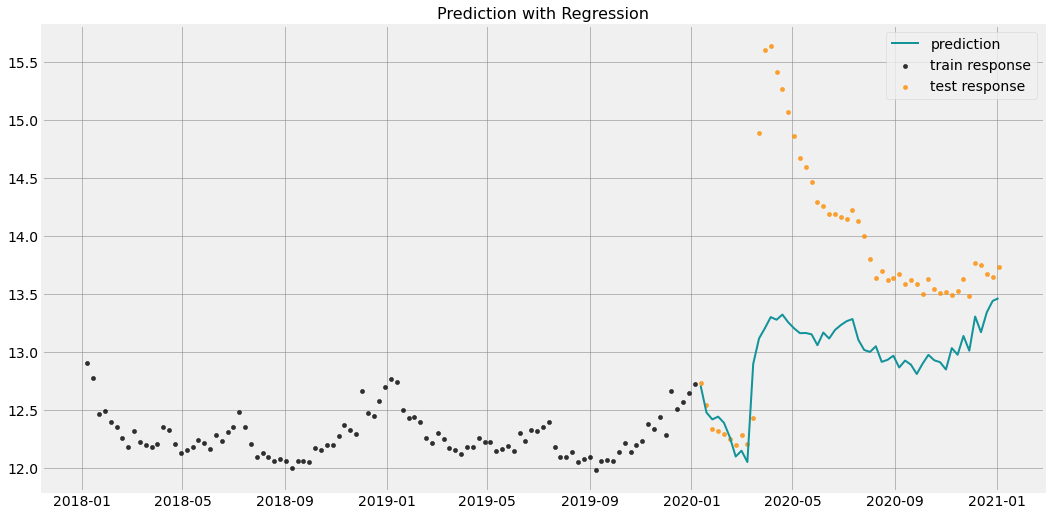

In [50]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction with Regression')

### Adjust pirors for regressor beta and standard deviation

In [51]:
dlt_reg_adjust = DLTFull(
    response_col=response_col,
    date_col=date_col,
    regressor_col=REGRESSOR_COL,
    regressor_sign=["+", '+', '='], 
    regressor_beta_prior=[0.05, 0.05, 0],
    regressor_sigma_prior=[0.1, 0.1, 0.1],
    seasonality=52,
    seed=1
)
dlt_reg_adjust.fit(df=train_df)

One can notice the significant changes in the estimted coefficients by using different priors.

In [52]:
dlt_reg_adjust.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Positive,0.099857
1,trend.filling,Positive,0.109657
2,trend.job,Regular,0.010449


In [53]:
predicted_df_reg_adjust = dlt_reg_adjust.predict(test_df)

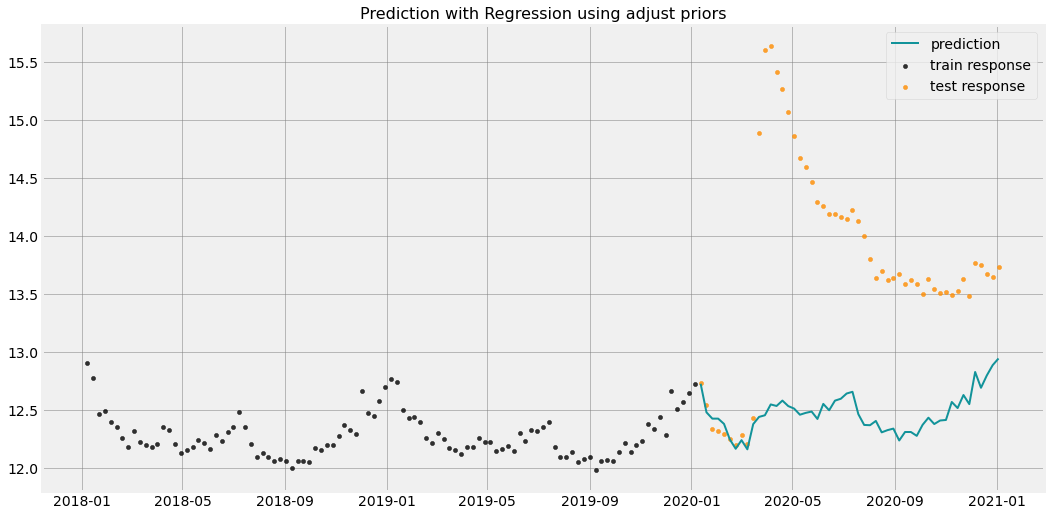

In [54]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg_adjust, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction with Regression using adjust priors')

### Use data-driven sigma for each coefficients

In [55]:
dlt_reg_ridge = DLTFull(
    response_col=response_col,
    date_col=date_col,
    regressor_col=REGRESSOR_COL,
    regressor_sign=["+", '+', '='],
    seasonality=52,
    seed=1,
    regression_penalty="auto_ridge",
    auto_ridge_scale=0.5,
)
dlt_reg_ridge.fit(df=train_df)

In [56]:
dlt_reg_ridge.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Positive,0.161784
1,trend.filling,Positive,0.148017
2,trend.job,Regular,0.000384


In [57]:
predicted_df_reg_ridge = dlt_reg_ridge.predict(test_df)

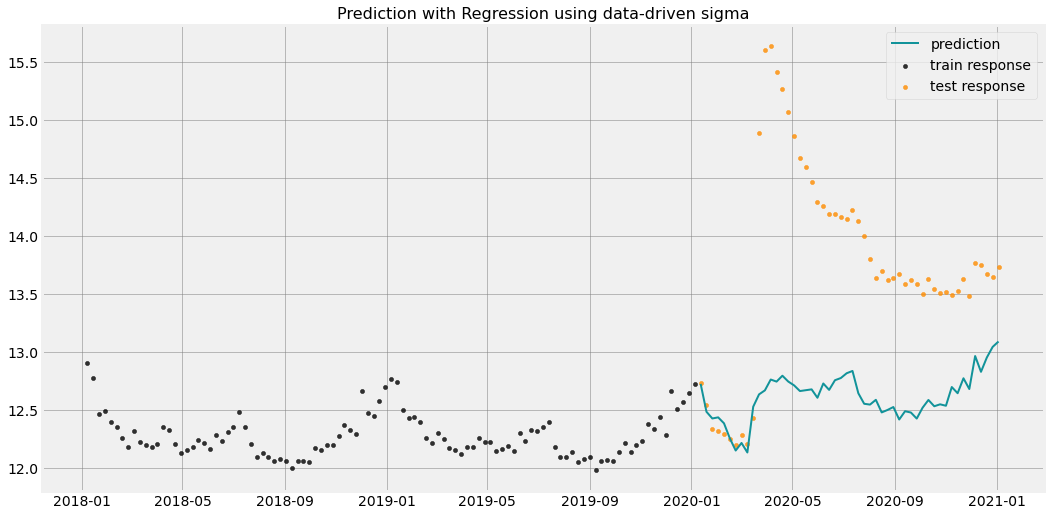

In [58]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg_ridge, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction with Regression using data-driven sigma')

# With Simulated Regression Dataset with Trend

Leverage the simulation function to generate a dateset with regression terms

In [177]:
# To scale regressor values in a nicer way
SEED = 2020
NUM_OF_REGRESSORS = 5
COEFS = np.random.default_rng(SEED).normal(.03, .1, NUM_OF_REGRESSORS)
COEFS

array([ 0.15602066,  0.05231785,  0.16325487, -0.11182046,  0.0027203 ])

In [178]:
x, y, coefs = make_regression(200, COEFS, seed=SEED)

In [179]:
df = pd.DataFrame(x)
regressor_cols = [f"regressor_{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
df.columns = regressor_cols
#df[regressor_cols] = df[regressor_cols]/REG_BASE
#df[regressor_cols] = df[regressor_cols].apply(np.log1p)

# min max scale to avoid negetive values
response_col = "response"
df[response_col] = y 
df[response_col] = minmax_scale(df[response_col])

# add the date column
df['date'] = pd.date_range(start='2016-01-04', periods=200, freq="1W")

In [180]:
df.head()

,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,response,date
0,0.630103,0.111589,0.000000,-0.709102,-0.136399,0.724856,2016-01-10
1,0.000000,0.125509,0.136342,-0.880252,0.543985,0.535811,2016-01-17
2,-0.000000,0.292064,0.192392,0.000000,0.042711,0.713783,2016-01-24
3,0.666333,-0.000000,-0.240312,-0.408502,0.000000,0.248319,2016-01-31
4,0.593637,-0.256724,-0.000000,0.031756,0.546676,0.440959,2016-02-07


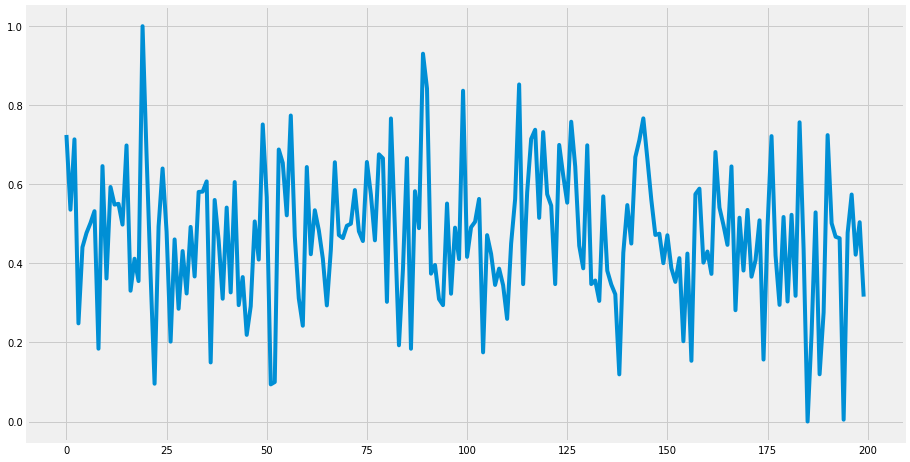

In [181]:
plt.plot(df['response'])

In [182]:
mod_auto_ridge = DLTFull(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    regression_penalty='auto_ridge',
    num_warmup=4000,
    num_sample=1000,
    stan_mcmc_control={'adapt_delta':0.9}
)
mod_auto_ridge.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [183]:
mod_fixed_ridge1 = DLTFull(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.5] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000
)
mod_fixed_ridge1.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [184]:
mod_fixed_ridge2 = DLTFull(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.05] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000
)
mod_fixed_ridge2.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [185]:
coef_auto_ridge = np.median(mod_auto_ridge._posterior_samples['beta'], axis=0)
coef_fixed_ridge1 = np.median(mod_fixed_ridge1._posterior_samples['beta'], axis=0)
coef_fixed_ridge2 = np.median(mod_fixed_ridge2._posterior_samples['beta'], axis=0)

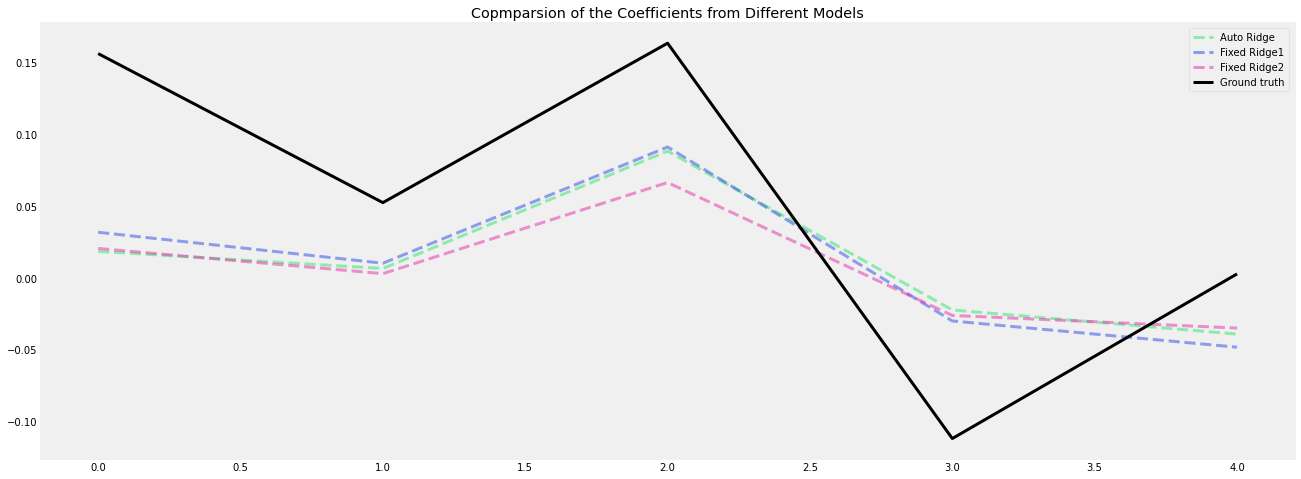

In [186]:
lw = 3
plt.figure(figsize=(20, 8))
plt.title("Copmparsion of the Coefficients from Different Models")
plt.plot(coef_auto_ridge, color=QualitativePalette.Line4.value[1], linewidth=lw, label="Auto Ridge", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge1, color=QualitativePalette.Line4.value[2], linewidth=lw, label="Fixed Ridge1", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge2, color=QualitativePalette.Line4.value[3], linewidth=lw, label="Fixed Ridge2", alpha=0.5, linestyle='--')
plt.plot(coefs, color="black", linewidth=lw, label="Ground truth")
plt.legend()
plt.grid()

The result looks reasonable comparing to the true coefficients.